# QuaSaR: Identifying EEW Rings - MMI Classifier

[Quake Safe Rings](./1a_stations_faultlnes_plot.ipynb) - In the efforts to understand the GeoNet datasets for havesting data that can be used in trialing the picking agorithms, we begin with the [GeoNet Strong Motion Database](https://www.geonet.org.nz/data/supplementary/nzsmdb), [rupture  model data](), and [processed recordings]() that are readily available<sup>[1](#myftnote1)</sup>. The idea is to classify the historic data by the various measures made available throught the datasets. Some of the measures include the moment magnitude, hycenter location, measuring station locations, tectonic type, rupture length, total duration, and so on.

<a name="ftnote1">[1]</a>: [All GeoNet data and images](https://github.com/GeoNet/data), with updates on Github, are made available free of charge through the GeoNet project to facilitate research into hazards and assessment of risk. GeoNet is sponsored by the New Zealand Government through its agencies: Earthquake Commission (EQC), GNS Science and Land Information New Zealand (LINZ), the National Emergency Management Agency (NEMA) and the Ministry of Business, Innovation and Employment (MBIE).

In [6]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

import logging
from functools import lru_cache

## Hueristically mining the strong motion database

[Flatfile specifications](https://static.geonet.org.nz/info/resources/applications_data/earthquake/strong_motion/Flatfiles_ColumnExplanation.pdf). They contain the horizontal and vertical acceleration response spectra, and horizontal and vertical Fourier amplitude spectra of acceleration.

We begin with mining the data with attention 
1. _Mw_: Moment Magnitude
1. _Orign_time_: Earthquake originating time
1. _TectClass_: Tectonic Class of crustal, slab, or interface
1. _Mech_: Focal mechanism whether it is a slip, strike, etc
1. _Length_km_: rupture length in Kilometers
1. _Width_km_: rupture width in Kilometers
1. _TotalDuration_: Total duration of the earthquake

### Class to load and clean data

In [3]:
#import torch
import pandas as pd
import datetime as dt
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

'''
    CSV LOAD into DataFrame and remove unnecessary columns
'''
strong_motion_df = pd.read_csv('../data/flatfiles/NZdatabase_flatfile_Significant_Duration_horizontal.csv', encoding = "UTF-8")

strong_motion_df = strong_motion_df.drop(columns=['CuspID','References','Location','Record'], axis=1)
strong_motion_df = strong_motion_df.replace('>2',float(2.1))
strong_motion_df = strong_motion_df.replace('<0.1',float(0.1))
''' Convert datetime to a defined as YYYYMMDD time rounded to 0 or 1 day '''
for t_idx, t_val in enumerate(strong_motion_df['Origin_time']):
    t_dt = dt.datetime.fromisoformat(t_val[0:19])
    t_float = float(t_dt.year*100000+t_dt.month*1000+t_dt.day*10+(round(t_dt.hour/24)))
    strong_motion_df['Origin_time'][t_idx]=t_float

_lst_cate_data_cols = [
                        'Origin_time',     # Origin time of earthquake in UTC
                        'TectClass',       # Tectonic classification, either ‘crustal’, ‘interface’, or ‘slab’
                        'Mech',            #
                        'HWFW',            #
                        'SiteCode',        #
                        'SiteClass1170',   #
                        'Vs30Uncert',      #
                        'TsiteUncert',     #
                        'Z1Uncertainty'    #
                      ]
cat_strong_motion_df = strong_motion_df[_lst_cate_data_cols]
num_strong_motion_df = strong_motion_df.drop(_lst_cate_data_cols, axis=1)
print(f"Shape of the Categorical DataFrame: {cat_strong_motion_df.shape}")
print(f"Shape of the Numerical DataFrame: {num_strong_motion_df.shape}")

''' LabelEncoder to convert the categorical data to numerical float64 '''
le = LabelEncoder()
for __cat_col_name in _lst_cate_data_cols:
    strong_motion_df[__cat_col_name] = le.fit_transform(strong_motion_df[__cat_col_name]).astype(float) 
print(f"Shape of the full DataFrame: {strong_motion_df.shape}")
print(f'\nPost label encoding of categorical data \n{strong_motion_df.head(3)}')

Shape of the Categorical DataFrame: (4291, 9)
Shape of the Numerical DataFrame: (4291, 46)
Shape of the full DataFrame: (4291, 55)

Post label encoding of categorical data 
   Origin_time    Mw  MwUncert  TectClass  Mech  PreferredFaultPlane  Strike  \
0          0.0  5.70      0.15        0.0   3.0                    1     242   
1          2.0  5.62      0.15        2.0   0.0                    1     250   
2          2.0  5.62      0.15        2.0   0.0                    1     250   

   Dip   Rake  HypLat  ...  TotalDuration  D5_75_H1_sec  D5_75_H2_sec  \
0   83  207.0  -42.13  ...          42.09          3.96          3.33   
1   56  257.0  -40.34  ...          25.96          3.22          2.09   
2   56  257.0  -40.34  ...          52.58          2.63          5.92   

   D5_75_GM_sec  D5_95_H1_sec  D5_95_H2_sec  D5_95_GM_sec  D20_80_H1_sec  \
0          3.63         12.02         11.29         11.65           3.93   
1          2.59          6.90          6.19          6.54    

### Method to pariwise plot measures

Description of each plotted measure: 
                count        mean        std    min      25%      50%  \
Origin_time    4291.0  163.811233  66.732684   0.00  111.500  185.000   
Mw             4291.0    5.298979   1.010330   3.54    4.530    5.180   
TectClass      4291.0    0.850151   0.949131   0.00    0.000    0.000   
Mech           4291.0    2.291773   1.374145   0.00    1.000    3.000   
LENGTH_km      4291.0   10.257285  20.588936   0.50    1.700    3.700   
TotalDuration  4291.0  100.098649  57.790764  25.00   51.995   90.855   

                   75%      max  
Origin_time    215.000  252.000  
Mw               5.900    7.850  
TectClass        2.000    2.000  
Mech             3.000    4.000  
LENGTH_km        8.000  100.230  
TotalDuration  131.995  327.675  


Text(0.5, 0.98, 'Pair Plots for relevant measures')

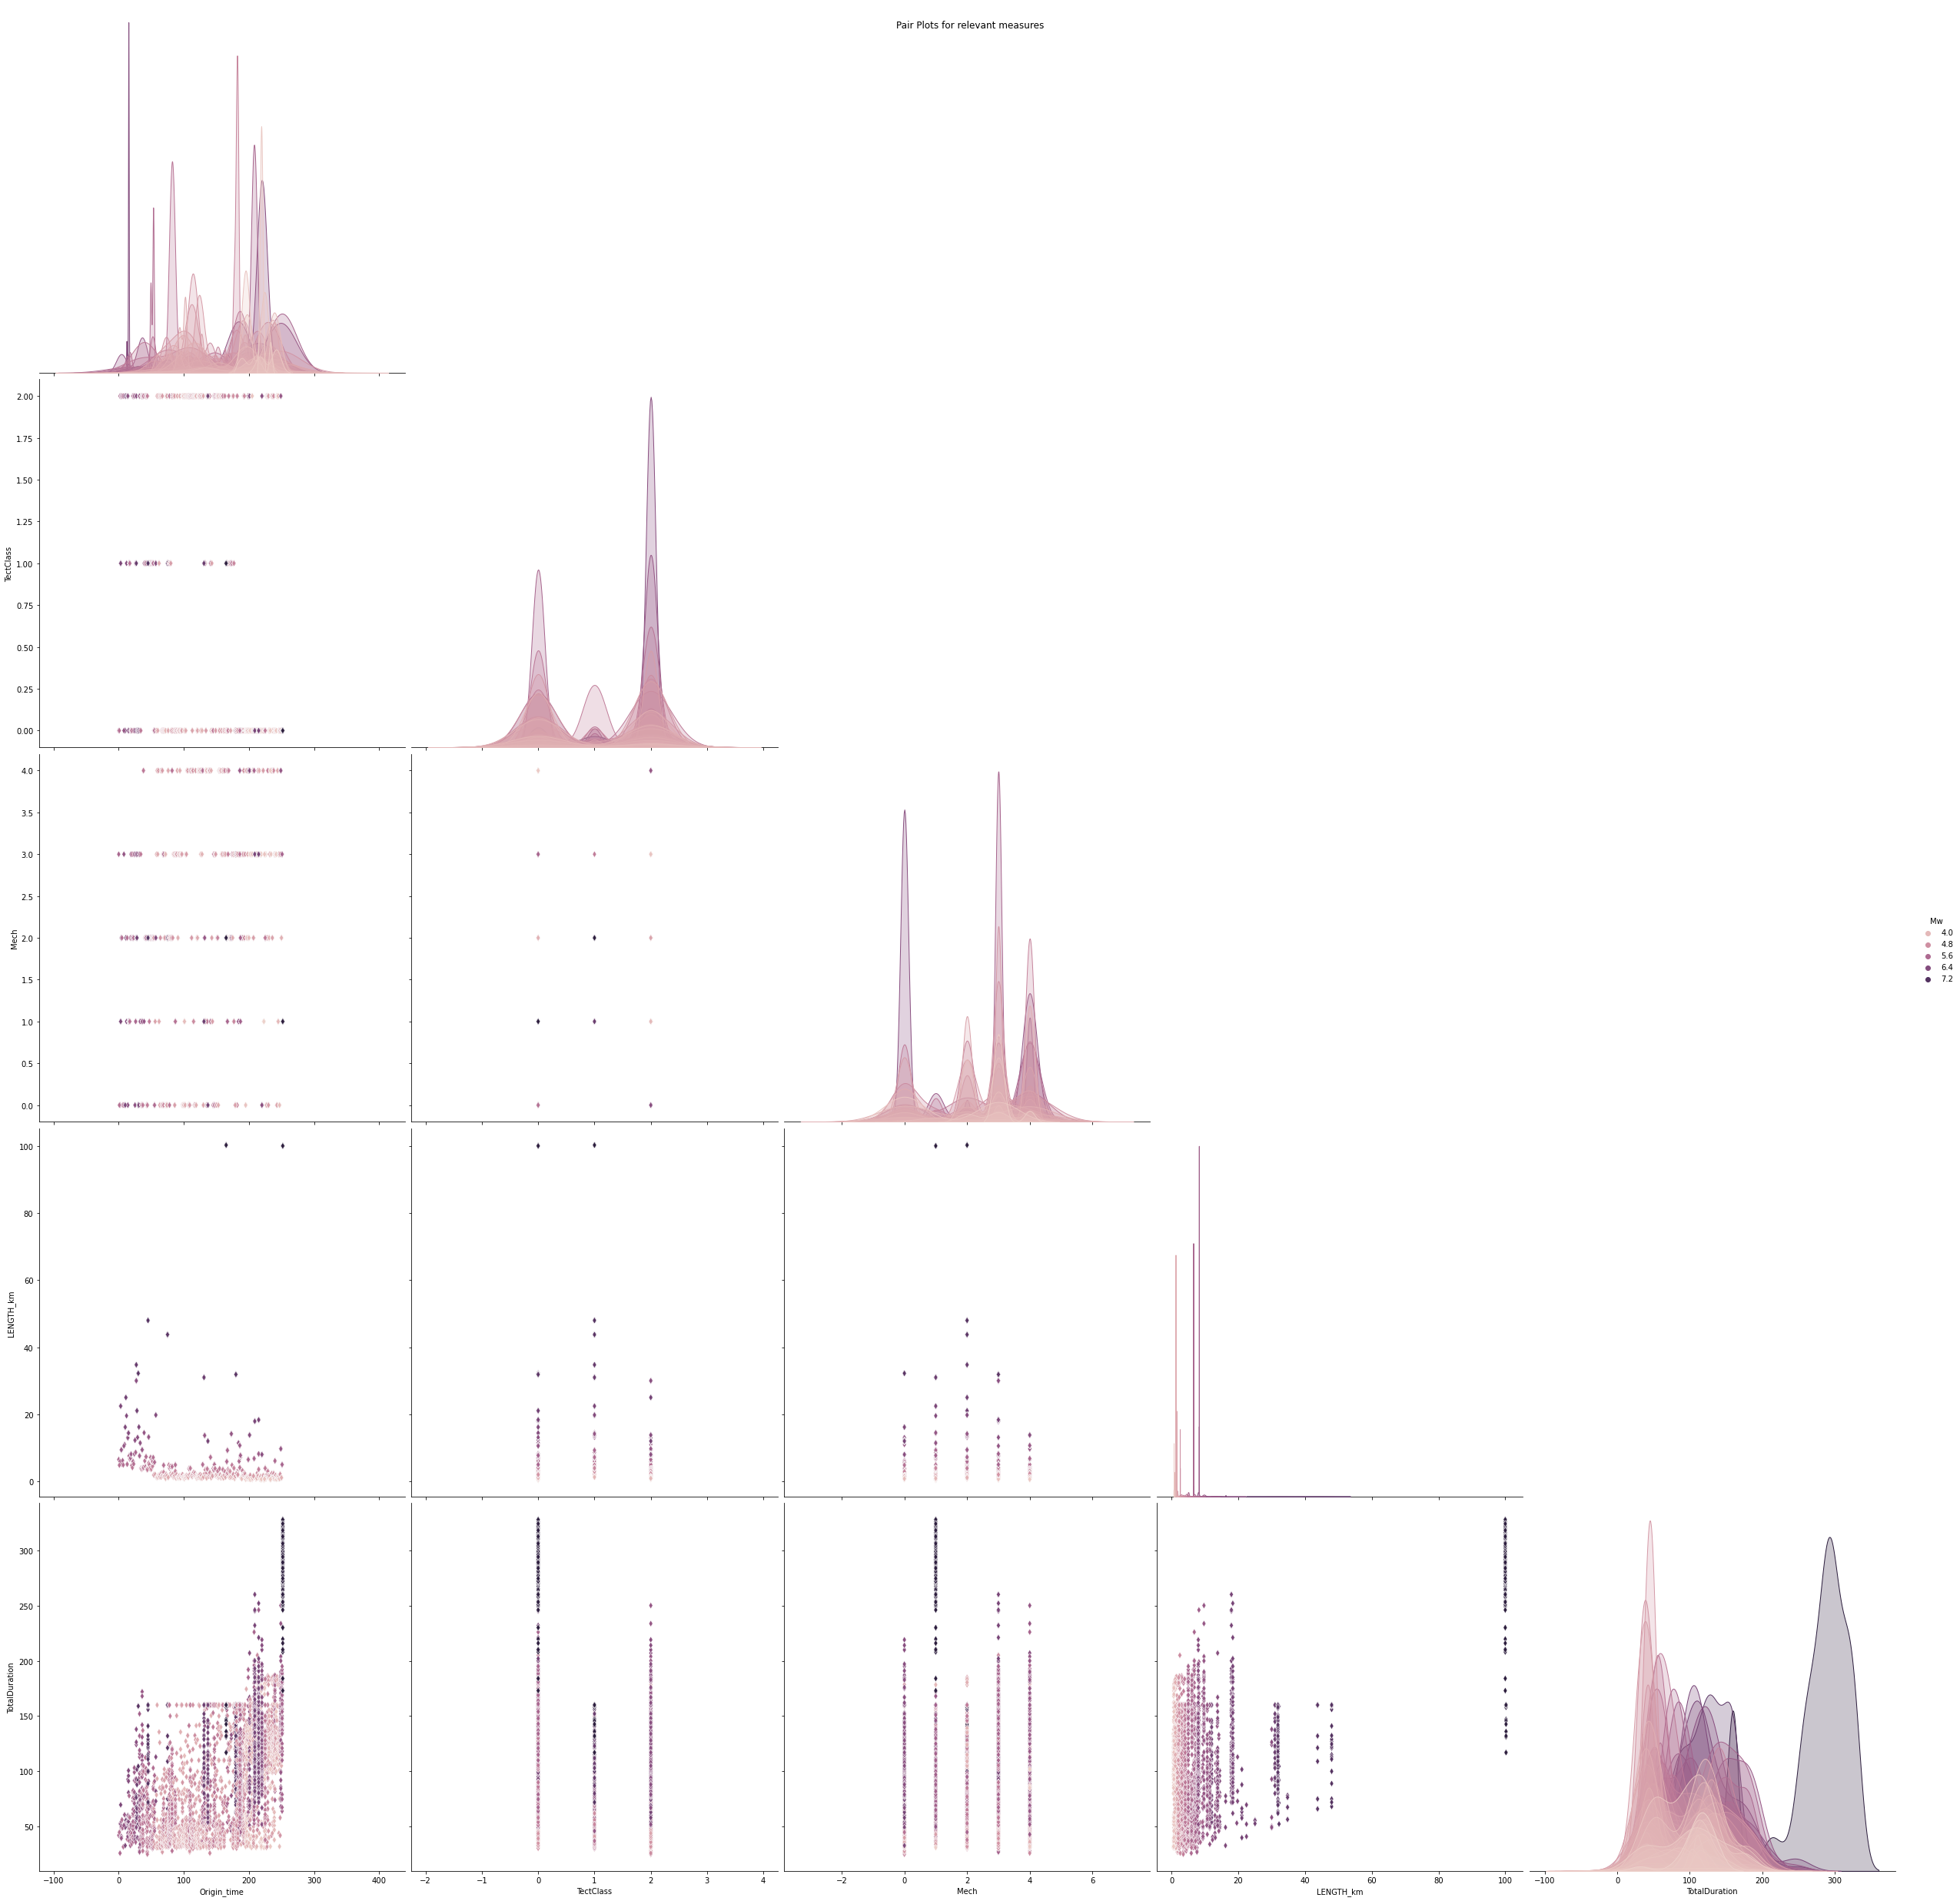

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
'''
    Pairwise density plots for all the column variables
    attribute specs: https://static.geonet.org.nz/info/resources/applications_data/earthquake/strong_motion/Flatfiles_ColumnExplanation.pdf
'''
plot_df = strong_motion_df[[
                            'Mw',          # Moment Magnitude
                            'MwUncert',    # Mw uncertainty class 
                            'Origin_time', # Origin time of earthquake in UTC
                            'TectClass',   # Tectonic classification, either ‘crustal’, ‘interface’, or ‘slab’
                            'Mech',        # Focal mechanism: S→strike-slip, N→normal,R→reverse,U→unknown
                            'PreferredFaultPlane', # 1→one fault plane orientation is preferred, 1→Unknown
                            'Strike',      # Strike angle (degrees)
                            'Dip',         # Dip angle (degrees)
                            'Rake',        # Rake angle (degrees)
                            'HypLat',      # Hypercenter Latitude
                            'HypLon',      # Hypercernter Longitude
                            'StationLat',  # Recording Station Latitude
                            'StationLon',  # Recording Station Longitude
                            'HypN',        # Northing of Hyppercenter
                            'HypE',        # Easting of Hypercernter
                            'StationN',    # Northing of Station
                            'StationE',    # Easting of Station
                            'LENGTH_km',   # Infered rupture Length in Kilometers
                            'WIDTH_km',    # Infered down-dip rupture Width in Kilometers
                            'TotalDuration'# Total Duration of the earthquake
                           ]]
lst_plot_cols = ['Origin_time','Mw','TectClass','Mech','LENGTH_km','TotalDuration']
print(f"Description of each plotted measure: \n{pd.DataFrame(plot_df[lst_plot_cols].describe(include='all')).T}")
g = sns.pairplot(plot_df[lst_plot_cols], 
             hue='Mw', corner=True,hue_order=None,
             kind='scatter', diag_kind='auto', height=7,markers='d')
g.fig.suptitle("Pair Plots for relevant measures") # y= some height>1


## Applying an NN Classifier
The intent is to use data available from GeoNet strong motion and felt databases to encapsulate a a Modified Mercalli Intensity (MMI) score. We use an Artifical Nueral Network (NN) to classify the data from the several flat files. The reason to use an NN is because of the large volume of covariates in the dataset. Subsequently assess wether a the classifier contribute to the basis of proposing an MMI for a new scenario of the given covariates.

Of particular intetrest to this notebook is investigating the use of pytorch and tensor products and their capabilties to build a model for evaluating Objective II.C --  Picking earthquakes. For such we need to achieve the following steps
1. Encode or vectorize the data; especially with transforming categorical labels to numerical data; ideally as embeddings (currently only using the LabelEncoder instead of the HotEncoder)
1. [Split the data](https://palikar.github.io/posts/pytorch_datasplit/) to generate train, validation, and test datasets to,
   1. train it with 300 epochs to reach an acceptable long tail and near-zero softmax defined in the NN model
   1. validate 

### Method to split dataset into train, validation, & test

In [11]:
''' METHOD DATALOADER - build the training dataloader object'''
# Load necessary Pytorch packages
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import numpy as np

shuffle = True
test_train_split = 0.8
val_train_split = 0.2

dataset = strong_motion_df.drop(['Origin_time','SiteCode'], axis=1).astype(float)

dataset_size = len(dataset)
indices = list(range(dataset_size))
test_split = int(np.floor(test_train_split * dataset_size))

if shuffle:
    np.random.shuffle(indices)

train_indices, test_indices = indices[:test_split], indices[test_split:]
train_size = len(train_indices)
validation_split = int(np.floor((1 - val_train_split) * train_size))
train_indices, val_indices = train_indices[ : validation_split], train_indices[validation_split:]

#_targets = dataset[['TectClass','Mech']]
#_inputs = dataset.drop(['TectClass','Mech'], axis=1)
_targets = dataset['Mech']
_inputs = dataset.drop(['Mech'], axis=1)
print('Classes',set(_targets))

''' Train Loader '''
train_inputs = np.array(_inputs.iloc[train_indices], dtype=np.float32)
train_targets= np.array(_targets.iloc[train_indices], dtype=np.float32)

train_data = []
for i in range(len(train_inputs)):
    train_data.append([train_inputs[i], train_targets[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, num_workers=0, shuffle=False)
print("Train data loader length", str(len(train_loader)))

''' Validation Loader '''
val_inputs = np.array(_inputs.iloc[val_indices], dtype=np.float32)
val_targets= np.array(_targets.iloc[val_indices], dtype=np.float32)

val_data = []
for i in range(len(val_inputs)):
    val_data.append([val_inputs[i], val_targets[i]])
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, num_workers=0, shuffle=False)
print("Validation data loader length", str(len(val_loader)))

Classes {0.0, 1.0, 2.0, 3.0, 4.0}
Train data loader length 275
Validation data loader length 69


## The NN Model
[Description of the NN Layers and tuning the Hyperparameters](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a)

#### Input layer
Comprises both numerical and categorical data. We have generated embeddings for all the categorical data.
* ```n_features: int=46``` (of 55)

#### Built Layers
1. [Linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) takes ```n_features: int=46``` (of 55) and ```n_out_feature: int=2``` (of 5).

We are unable to use
1. [Pooling]()
1. [Convolusion]()
1. [Dropout]()

#### Hidden Layer
The design of the hidden layer makes use of

#### Output Layer
The output classifiers are ```output={'Mw','TectClass','Mech','Length_km','Width_km', 'TotalDuration'}```. Therefore, we have ```n_out_features: int=6```.

#### Weights
The weights are randomly generated for the ```2401 x 49``` tensors. 

In [71]:
import torch.nn as nn
import torch.nn.functional as F

class Net_old(nn.Module):
    
    def __init__(self, n_in_features: int, n_out_features: int, p=0.4):
        super().__init__()
#        self.dropout1 = nn.Dropout(p)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(n_in_features, n_out_features)
        
    def forward(self,x):
        # Use the rectified-linear activation function over x
        x = F.relu(x)
#        x = self.relu1(x)
#        x = self.dropout1(x)        
        # Pass data through fc1
        x = self.fc1(x)

        # Run max pooling over x
#        x = nn.LPPool1d(x, 2)
        # Pass data through dropout1
#        x = self.dropout1(x)
        # Flatten x with start_dim=1
#        x = torch.flatten(x, 1)
#        x = F.relu(x)
#        x = self.dropout2(x)
#        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output


In [80]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self, n_in_features: int, n_out_features: int, layers: list, p=0.4):
        super().__init__()
#        self.dropout1 = nn.Dropout(p)
#        self.relu1 = nn.ReLU(inplace=True)
#        self.fc1 = nn.Linear(n_in_features, n_out_features)
        
        all_layers = []
#        num_categorical_cols = sum((nf for ni, nf in embedding_size))
#        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.Linear(n_in_features, n_out_features))
#            all_layers.append(nn.BatchNorm1d(i))
#            all_layers.append(nn.Dropout(p))
#            input_size = i

#        all_layers.append(nn.Linear(layers[-1], n_out_features))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.layers(x)
        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output


### Method to initialize the NN Trainer

__Parameters__
* _n_in_features_:
* _n_out_features_:
* _layers_: List which contains number of neurons for all the layers
* _p_: 

In [81]:
train_loader_input, train_loader_target = next(iter(train_loader))
print(f"Train loader shape {train_loader_input.shape} and target loader shape {train_loader_target.shape}")
n_in_features = train_loader_input.shape[1]     # = 51
n_out_features = len(set(_targets))
print(f'Building model with {n_in_features} in features and {n_out_features} out features')
model = Net(n_in_features,n_out_features,layers=[1],p=0.4) # On CPU
#model = Net_old(n_in_features,n_out_features,p=0.4) # On CPU
print(f"\n{model}")

Train loader shape torch.Size([10, 52]) and target loader shape torch.Size([10])
Building model with 52 in features and 5 out features

Net(
  (layers): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=52, out_features=5, bias=True)
  )
)


### Method to build the Validation tensors

In [82]:
import torch.optim as optim

lr = 0.001

# Define loss funcion
loss_function = nn.CrossEntropyLoss()
# define optimizer
# TODO examine SDG and other optimizer protocols
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(f'Optimizer with learning rate lr={lr} and Parameters')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Optimizer with learning rate lr=0.001 and Parameters
layers.1.weight tensor([[-0.0296, -0.0118, -0.0474,  0.0163, -0.0402, -0.0907,  0.0711, -0.1049,
          0.1128,  0.1245, -0.0601, -0.1205,  0.0343,  0.0962,  0.1047,  0.0961,
          0.0287, -0.1183, -0.0238,  0.0793,  0.1303,  0.0548,  0.1271, -0.1164,
         -0.0233,  0.0080,  0.0592,  0.1384,  0.1075,  0.0398, -0.0187,  0.0486,
         -0.0944,  0.0714,  0.0082,  0.0477, -0.0666, -0.1060, -0.1033, -0.0898,
         -0.0447, -0.0660,  0.0921, -0.0826, -0.1252, -0.0677, -0.1218, -0.0207,
         -0.0956, -0.0748,  0.0291, -0.0494],
        [-0.0447, -0.0950, -0.0526, -0.0335, -0.0534,  0.0073, -0.0175, -0.1385,
         -0.1117,  0.0933, -0.0489,  0.1169, -0.0512, -0.1139, -0.0790,  0.0158,
          0.0648,  0.0956,  0.0437, -0.0340,  0.0745,  0.1102,  0.1090, -0.1382,
          0.0275, -0.0180,  0.0006,  0.1314,  0.0255,  0.1310, -0.0964, -0.0413,
         -0.0749,  0.0223, -0.0334,  0.1260, -0.0178, -0.0061, -0.1293, -0.

### Method to Train and Validate the NN model
good article on [training and validation](https://stackoverflow.com/questions/2976452/whats-is-the-difference-between-train-validation-and-test-set-in-neural-netwo)

In [74]:
val_loader_input, val_loader_target = next(iter(val_loader))
print(f"Validation loader shape {val_loader_input.shape} and target loader shape {val_loader_target.shape}")


Validation loader shape torch.Size([10, 52]) and target loader shape torch.Size([10])


In [104]:
epochs = 300
train_aggr_loss = []
train_accur = []
val_accur = []

print('Input train tensor data type:',train_loader_input.dtype,  'and', train_loader_input.size())
print('Target train tensor data type:',train_loader_target.dtype,  'and', train_loader_target.size())

print(f"Begin training for {epochs} epochs ...\n")
for i in range(epochs):
    i += 1
    train_correct = 0
    train_total = 0
    for train_idx, (train_data, train_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model.forward(train_data)
        _, train_predicted = torch.max(y_pred.data, 1)
#        print(f'{k} Output shape {y_pred.shape} and tensor looks like\n{y_pred[0:2]}')
        train_labels = train_labels.type(torch.LongTensor)
#        print(f'{k} Label shape {labels.shape} and tensor looks like\n{labels}')
        train_single_loss = loss_function(y_pred, train_labels)
    
        train_single_loss.backward()
        optimizer.step()

        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()

    train_accur.append(100 * train_correct / train_total)
    train_aggr_loss.append(train_single_loss)

    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_idx, (val_data, val_labels) in enumerate(val_loader):
#            print(k, data, labels)
            val_labels = val_labels.type(torch.LongTensor)
            y_pred = model.forward(val_data)
            _, val_predicted = torch.max(y_pred.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accur.append(100 * val_correct / val_total)

#    print(f'NN accuracty on the {data.size()} test images: %d %%' % (100 * correct / total))


    if i%25 == 1:
        print(f'epoch: {i:3} training loss: {train_single_loss.item():10.4f}')
        print(f'epoch: {i:3} training accuracy: {(train_predicted == train_labels).sum().item():10.4f}%')
        print(f'epoch: {i:3} validation accuracy: {(val_predicted == val_labels).sum().item():10.4f}%')

print(f'epoch: {i:3} loss: {train_single_loss.item():10.10f}')
print(f'epoch: {i:3} training accuracy: {(train_predicted == train_labels).sum().item():10.4f}%')
print(f'epoch: {i:3} validation accuracy: {(val_predicted == val_labels).sum().item():10.4f}%')


Input train tensor data type: torch.float32 and torch.Size([10, 52])
Target train tensor data type: torch.float32 and torch.Size([10])
Begin training for 300 epochs ...

epoch:   1 training loss:  1874.6000
epoch:   1 training accuracy:     3.0000%
epoch:   1 validation accuracy:     0.0000%
epoch:  26 training loss:     0.0000
epoch:  26 training accuracy:     5.0000%
epoch:  26 validation accuracy:     0.0000%
epoch:  51 training loss:   168.9500
epoch:  51 training accuracy:     4.0000%
epoch:  51 validation accuracy:     0.0000%
epoch:  76 training loss:   154.7000
epoch:  76 training accuracy:     4.0000%
epoch:  76 validation accuracy:     0.0000%
epoch: 101 training loss:     0.0000
epoch: 101 training accuracy:     5.0000%
epoch: 101 validation accuracy:     3.0000%
epoch: 126 training loss:  2077.1877
epoch: 126 training accuracy:     2.0000%
epoch: 126 validation accuracy:     6.0000%
epoch: 151 training loss:   344.5000
epoch: 151 training accuracy:     4.0000%
epoch: 151 va

Text(0.5, 1.0, 'Aggregated losses over 300')

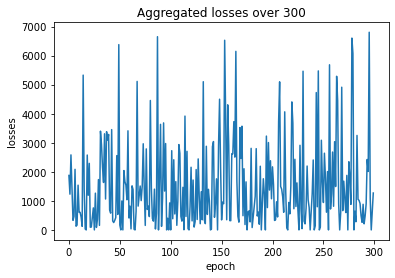

In [107]:
#print(len(aggregated_losses))
plt.plot(range(epochs), train_aggr_loss)
plt.ylabel('losses')
plt.xlabel('epoch');
plt.title(f'Aggregated losses over {epochs}')

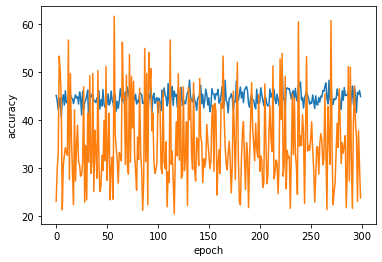

In [106]:
plt.plot(range(epochs), train_accur)
plt.plot(range(epochs), val_accur)
plt.ylabel('accuracy')
plt.xlabel('epoch');

### OneHotEncoding [DEPRECATE?]

In [ ]:
'''
    DEPRECATE if the LabelEncoding is sufficient; else,
    TODO: OneHotEncode before building the the tensors
'''

import logging
from functools import lru_cache

logging.debug('Preprocessing data with OneHotEncoder')

'''
    OneHotEncoder to create the arrays for training, validation, and testing
'''
train_1hotenc = np.empty_like(train_ts)
for t_indx, t in enumerate(train_ts):
    print(t_indx,t.numpy())
    train_1hotenc[t_indx] = OneHotEncoder(categories='auto', drop=None, sparse=True, dtype='float64', 
                                  handle_unknown='error').fit_transform(t.numpy())
    print(train_1hotenc[t_indx])
train_1hotenc_ts = train_1hotenc
print(f"Shape of the OneHotencoded array: {train_1hotenc.shape}")
print(f"Datatype of the OneHotencoded array: {train_1hotenc.dtype}")